# Model 2: With undersampling 

Note: The code has been executed after the presentation was made, numbers may thus vary from presentation material.

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#import data 
dfall = pd.read_csv('CreditCardFraud_AllData.csv')
df3 = pd.read_csv('CreditCardFraud_3.csv')

In [3]:
# Transform the data in the columns Time and Amount 
std_scaler = StandardScaler()

dfall['scaled_amount'] = std_scaler.fit_transform(dfall['Amount'].values.reshape(-1,1))
dfall['scaled_time'] = std_scaler.fit_transform(dfall['Time'].values.reshape(-1,1))
dfall.drop(['Time','Amount'], axis=1, inplace=True)

df3['scaled_amount'] = std_scaler.fit_transform(df3['Amount'].values.reshape(-1,1))
df3['scaled_time'] = std_scaler.fit_transform(df3['Time'].values.reshape(-1,1))
df3.drop(['Time','Amount'], axis=1, inplace=True)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Create undersampled dataset

In [4]:
random.seed(20)
#Create an undersampled version of the dataset to use to build the model

# Count number of data points in the minority class
fraud_count = len(df3[df3['Is.Fraud'] == 1])

# Create separate arrays for the different cases (fraud / not fraud)
fraud_trans = np.array(df3[df3['Is.Fraud'] == 1].index)
normal_trans = df3[df3['Is.Fraud'] == 0].index

# Out of the normal transactions, select "fraud_count" number of transactions randomly
random_normal_trans = np.random.choice(normal_trans, fraud_count, replace = False)
random_normal_trans = np.array(random_normal_trans)

# Combining the normal and fraud transaction
under_sample_trans = np.concatenate([fraud_trans,random_normal_trans])

# Create the undersampled dataset
under_sample_data = df3.iloc[under_sample_trans,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Is.Fraud']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Is.Fraud']

# Print result
print("Proportion of non-fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 0])/len(under_sample_data))
print("Proportion of fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 1])/len(under_sample_data))
print("Total number of transactions in undersampled data: ", len(under_sample_data))

Proportion of non-fraud transactions:  0.5
Proportion of fraud transactions:  0.5
Total number of transactions in undersampled data:  984


In [5]:
from sklearn.utils import shuffle

#shuffle data
under_sample_data = shuffle(under_sample_data)
print(under_sample_data.head())

      Is.Fraud        V1        V2        V3        V4        V5        V6  \
4989      True -7.503926 -0.360628 -3.830952  2.486103  2.497367  1.332437   
3644     False  1.835749  0.095032 -0.145201  3.533239  0.152116  1.221709   
4996      True  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
4765      True -1.410852  2.268271 -2.297554  1.871331  0.248957 -1.208799   
3486     False  2.115689 -0.628392 -1.277827 -0.831985 -0.460271 -0.696340   

            V7         V8        V9     ...            V21       V22  \
4989 -6.783964 -15.415385  0.465512     ...      -6.389132  2.249964   
3644 -0.715531   0.432291 -0.431166     ...       0.277294  0.747301   
4996 -1.413170   0.248525 -1.127396     ...       0.370612  0.028234   
4765 -1.358648   1.102916 -1.317364     ...       0.155381 -0.614880   
3486 -0.645321  -0.059615 -0.465363     ...      -0.297317 -0.927760   

           V23       V24       V25       V26       V27       V28  \
4989  1.670508  0.140450  0.16

True     492
False    492
Name: Is.Fraud, dtype: int64


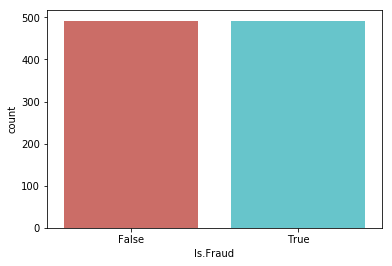

In [6]:
#count how many are of each class in the undersampled dataframe: Fraud or not fraud
fraud_class = under_sample_data['Is.Fraud'].value_counts()
print(fraud_class)
sns.countplot(x='Is.Fraud',data=under_sample_data, palette='hls')

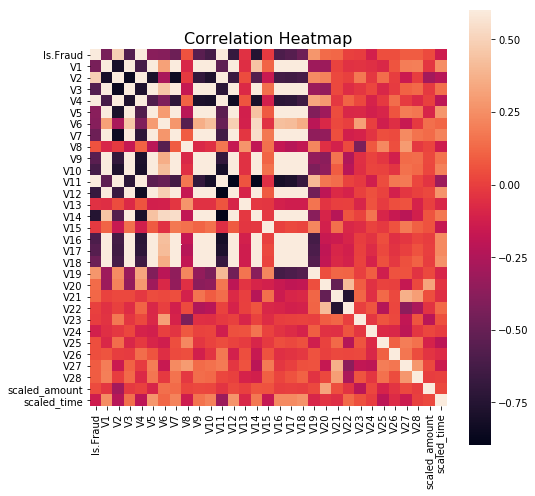

In [7]:
correlation = under_sample_data.corr()
f , ax = plt.subplots(figsize = (8,8)) 
plt.title('Correlation Heatmap',y=1,size=16) 
sns.heatmap(correlation, square = True, vmax=0.6)

In [8]:
#want to find the features which have the strongest correlation with fraud
correlation = under_sample_data.corr()['Is.Fraud'][1:]

#Make a list of the features which have a correlation with absolute value larger than 0.5 to list out
features_list = correlation[abs(correlation) > 0.5].sort_values(ascending=False)
print("There is {} values which are notably correlated with Is.Fraud:\n{}".format(len(features_list), features_list))

There is 9 values which are notably correlated with Is.Fraud:
V4     0.708998
V11    0.681027
V9    -0.549836
V17   -0.558898
V3    -0.568032
V16   -0.596368
V10   -0.624206
V12   -0.683462
V14   -0.752386
Name: Is.Fraud, dtype: float64


In [9]:
# Choose the columns we want to use to predict fraud with using correlation
names = ['Is.Fraud','V3', 'V4','V9', 'V10','V11', 'V12', 'V14','V16','V17']
train_cols = names[1:]

# Use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.379722
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Jan 2019   Pseudo R-squ.:                  0.4522
Time:                        12:51:07   Log-Likelihood:                -373.65
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                5.656e-128
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V3            -0.1718      0.065     -2.626      0.009      -0.300      -0.044
V4             0.2255      0

In [11]:
X3 = df3.iloc[:, df3.columns != 'Is.Fraud']
y3 = df3.iloc[:, df3.columns == 'Is.Fraud']

# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols],df3['Is.Fraud'],test_size = 0.3, random_state = 0)


# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

In [12]:
print(df3[train_cols].head())
print(under_sample_data[train_cols].head())

         V3        V4        V9       V10       V11       V12       V14  \
0  0.924591 -0.727219 -0.665271 -0.737980  0.324098  0.277192 -0.291896   
1  1.146088  0.656290 -0.523849  0.690440  1.160793  0.831569 -0.018098   
2 -0.268073  0.125245 -0.230000  0.295110 -0.596572 -0.118181  0.063381   
3  1.230334  2.554474  0.307571  0.475235 -1.410625 -0.508594 -0.199105   
4  2.528964  0.648279  0.435493 -0.308060 -0.678178 -0.219642 -0.383811   

        V16       V17  
0  1.143174 -0.928709  
1 -0.180816 -0.749369  
2 -0.608157 -0.159370  
3  0.541796 -0.274024  
4 -0.471960  0.419925  
            V3        V4        V9       V10       V11       V12       V14  \
4989 -3.830952  2.486103  0.465512 -0.394381  1.054107  0.974059 -1.425620   
3644 -0.145201  3.533239 -0.431166  1.587057 -0.205359 -0.310894  0.186180   
4996 -5.004247  1.411850 -1.127396 -3.232153  2.858466 -3.096915 -5.210141   
4765 -2.297554  1.871331 -1.317364 -4.626919  3.357640 -2.998815 -6.766633   
3486 -1.277827 

In [13]:
#we fit and predict a model on the undersampled data first
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [14]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[157   9]
 [  4 126]]


Text(0.5,257.44,'Predicted label')

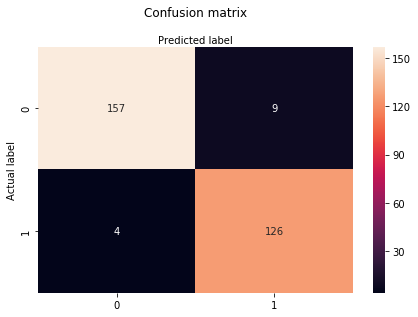

In [15]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.98      0.95      0.96       166
       True       0.93      0.97      0.95       130

avg / total       0.96      0.96      0.96       296



In [17]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [18]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1311   40]
 [  14  135]]
             precision    recall  f1-score   support

      False       0.99      0.97      0.98      1351
       True       0.77      0.91      0.83       149

avg / total       0.97      0.96      0.97      1500



Text(0.5,257.44,'Predicted label')

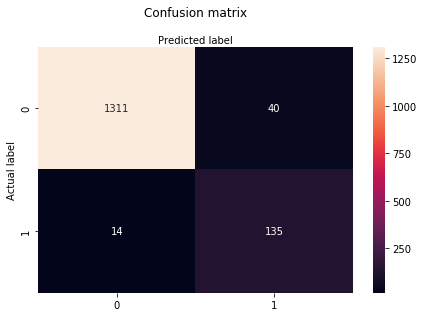

In [20]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Model 3: Feature selection

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, RandomizedLasso
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [22]:
logreg = LogisticRegression()

#specify that we want 9 features to compare with our own selection above
rfe = RFE(logreg, 9)
rfe = rfe.fit(X_undersample, y_undersample.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print('Selected features: %s' % list(X_undersample.columns[rfe.support_]))

[False  True False  True False False False False  True  True False  True
 False  True False False False False False  True False False False False
 False  True False  True False False]
[16  1 10  1 14 18 13  2  1  1  4  1  8  1 15  5  6  7 11  1 20  3  9 22
 21  1 19  1 17 12]
Selected features: ['V2', 'V4', 'V9', 'V10', 'V12', 'V14', 'V20', 'V26', 'V28']


In [28]:
#select the features from the rfe to build model
names = ['Is.Fraud','V2', 'V4', 'V9', 'V10', 'V12', 'V14', 'V20', 'V26', 'V28']
train_cols3 = names[1:]

#We use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols3]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.382272
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Tue, 15 Jan 2019   Pseudo R-squ.:                  0.4485
Time:                        12:55:27   Log-Likelihood:                -376.16
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                6.784e-127
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V2            -0.0730      0.062     -1.182      0.237      -0.194       0.048
V4             0.2435      0

In [29]:
# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols3],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols3],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X_train))
print("Transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

Transactions train dataset:  688
Transactions test dataset:  296
Total transactions:  984


In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[159   7]
 [  6 124]]


In [33]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.96      0.96      0.96       166
       True       0.95      0.95      0.95       130

avg / total       0.96      0.96      0.96       296



In [34]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy: 0.95


In [35]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix and metrics
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1290   61]
 [  14  135]]
             precision    recall  f1-score   support

      False       0.99      0.95      0.97      1351
       True       0.69      0.91      0.78       149

avg / total       0.96      0.95      0.95      1500



Text(0.5,257.44,'Predicted label')

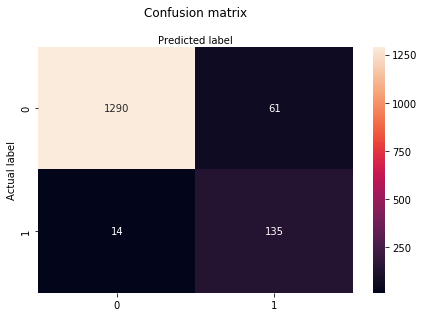

In [36]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')